In [4]:
import os
os.sys.path

['C:\\Users\\ASUS\\Project SMAI',
 'E:\\Anaconda3\\python38.zip',
 'E:\\Anaconda3\\DLLs',
 'E:\\Anaconda3\\lib',
 'E:\\Anaconda3',
 '',
 'E:\\Anaconda3\\lib\\site-packages',
 'E:\\Anaconda3\\lib\\site-packages\\locket-0.2.1-py3.8.egg',
 'E:\\Anaconda3\\lib\\site-packages\\win32',
 'E:\\Anaconda3\\lib\\site-packages\\win32\\lib',
 'E:\\Anaconda3\\lib\\site-packages\\Pythonwin',
 'E:\\Anaconda3\\lib\\site-packages\\IPython\\extensions',
 'C:\\Users\\ASUS\\.ipython']

In [5]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [6]:
DATADIR = "D:\ImageCLEFphoto2008\images\images"
subfolders = os.listdir(DATADIR)
images_path = []
images = []
path = ''
for i in range(5):
    for subfolder in subfolders:
        
        path = DATADIR+'/'+subfolder+'/'
        images = os.listdir(path)
        
        for imagepath in images:
            images_path.append(path+'/'+imagepath)

print(len(images_path))

100000


##### we randomly select a subset of 10000 images. 
##### Randomly selecting 10000 images, which gives us $10000\times256 = 2560000$ points!

In [7]:
np.random.seed(39)
np.random.shuffle(images_path)  # Randomly shuffling the image names 
# Selecting +50 images to counter invalid image/path related issues
random_selection = np.random.choice(images_path, 10050,replace=False)  # We dont want repeated names, so replace = False

In [8]:
class VisualBagOfWords:
    def __init__(self):
        # tf-idf scores of images
        self.tf_idf = []
        # Inverse document frequency of images
        self.inv_doc_freq = []
        # K means estimator
        self.estimator = None
        # Cluster size
        self.k = 0
    
    
    def divideImageToCells(self,image):
        M = image.shape[0]
        N = image.shape[1]
        # Dividing the image into 16*16 gird of cells
        m = M//16
        n = N//16

        M = m*16   # To make sure that m is multiple of M, so that we do not get smaller strip at the end of images
        N = n*16
        cells = []
        for i in range(0,M,m):
            for j in range(0,N,n):
                cells.append(image[i:i+m, j:j+n, :]) 
        return cells
    
    def calculateMSTDofCells(self,cells):
        # According to the given paper, each cell converted into a 6 dimensional vector
        # mean and standard deviation of R/R+B+G, G/R+B+G and R+B+G/3*255
        # Channel 0, 1 and 2 correspond to the color Red, Green and Blue.
        no_of_cells = len(cells)
        MSTD = []

        for i in range(no_of_cells):
            _6_d_vector = np.zeros(6)

            # We add div_array to the denominator so that we avoid RLE division by 0, when all channels are 0 (black pixel)
            div_array = np.ones((cells[0].shape[0], cells[0].shape[1]))*1e-7

            data = [None, None, None]
            data[0] = np.divide(cells[i][:,:,0], cells[i][:,:,0]+cells[i][:,:,1]+cells[i][:,:,2]+div_array)
            data[1] = np.divide(cells[i][:,:,1], cells[i][:,:,0]+cells[i][:,:,1]+cells[i][:,:,2]+div_array)
            data[2] = (cells[i][:,:,0]+cells[i][:,:,1]+cells[i][:,:,2])/(3*255)

            for i in range(3):
                _6_d_vector[2*i] = np.mean(data[i])         # Mean
                _6_d_vector[2*i + 1] = np.std(data[i])      # Standard deviation

            MSTD.append(_6_d_vector)

        return MSTD
    def performKMeans(self, all_cell_statistics, cluster_size):
        self.k = cluster_size
        self.estimator = KMeans(n_clusters=self.k, random_state=42).fit(all_cell_statistics)

    def getVisualTermsOfImage(self,new_image):
        cells = self.divideImageToCells(new_image)           # Divide the image into cells
        statistics = self.calculateMSTDofCells(cells)         # Calculate the statistics for all the cells
        visual_terms = self.estimator.predict(statistics)
        return visual_terms


    def computeTfIdfScoredMSTD(self, images):
        # contains the term frequency of each image
        document_frequency = np.zeros(self.k)

        tf_idf = []
        print("Calculating tf-idf scores ...")
        
        for i in tqdm(range(len(images))):
            
            term_frequency = np.zeros(self.k)
            # Return labels of 256 cells of the images
            visual_terms = self.getVisualTermsOfImage(images[i])
            
            # Calculate the histogram
            for i in range(self.k):
                term_frequency[visual_terms[i]]+=1 
            # Add the elements that appear in this document
            document_frequency += (term_frequency>0)*1
            
            # K is 1.2 in Okapi formula. b is not necessary as the average size of documents is same as document size for all images
            term_frequency = (term_frequency*(1.2+1))/(term_frequency+1.2)
            tf_idf.append(term_frequency)
        
        inverse_document_frequency = np.log2((len(images)-document_frequency + 0.5)/(document_frequency+0.5))
        for i in range(len(images)):
            tf_idf[i] *= inverse_document_frequency
            
        self.tf_idf = tf_idf
        self.inv_doc_freq = inverse_document_frequency
        

    def calculateVisualScore(self,query_image):
        visual_terms_query = self.getVisualTermsOfImage(query_image)
        # The below is calculated according to the okapi method. Here term_frequency_query is same as qtw in paper
        term_frequency_query = np.zeros(self.k)
        for i in range(self.k):
                term_frequency_query[visual_terms_query[i]]+=1 
        
        # Here k_3 is 7, defined in okapi formula
        term_frequency_query = (term_frequency_query*(7+1))/(term_frequency_query+7)

        scores = np.zeros(len(self.tf_idf))
        print("Calculating scores ...")
        
        for i in tqdm(range(len(self.tf_idf))):
            score = np.sum(term_frequency_query*self.tf_idf[i])
            scores[i] = score
        
        matching_image_indices = scores.argsort()[::-1][:10]
        scores.sort()
        matching_image_scores = scores[::-1][:10]

        return matching_image_indices, matching_image_scores
    
    
    def prepareVisualBagOfWords(self, DATASET, cluster_size):
        all_cells_MSTD = []
        cells = MSTD = None 
        
        print('Dividing the images into cells, and calculating the statistics of each cell')
        
        for i in tqdm(range(len(DATASET))):
            cells = self.divideImageToCells(DATASET[i])
            MSTD = self.calculateMSTDofCells(cells)
            all_cells_MSTD += MSTD 
        
        print('Performing K-means on MSTD of images')
        self.performKMeans(all_cells_MSTD, cluster_size)  

In [9]:
# WORKFLOW
no_of_images = len(random_selection)
DATASET = []
DATASET_len = 10000
image = None   

print('Reading the images and converting to RGB format ...')

for i in tqdm(range(DATASET_len)):
    image = cv2.imread(random_selection[i])
    # To check if the image was read correctly
    if image is not None:
        # As the default color order of cv2 is BGR, we change it to RGB
        DATASET.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    else:
        i=-1
        

Reading the images and converting to RGB format ...


  0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
print("No of images in the dataset : ", len(DATASET))

No of images in the dataset :  9998


In [11]:
image_bow = VisualBagOfWords()
image_bow.prepareVisualBagOfWords(DATASET,cluster_size=200)

Dividing the images into cells, and calculating the statistics of each cell


  0%|          | 0/9998 [00:00<?, ?it/s]

Performing K-means on MSTD of images


In [12]:
test = DATASET[:10]
predictions = []
for i in range(9):
    predictions.append(image_bow.getVisualTermsOfImage(test[i]))

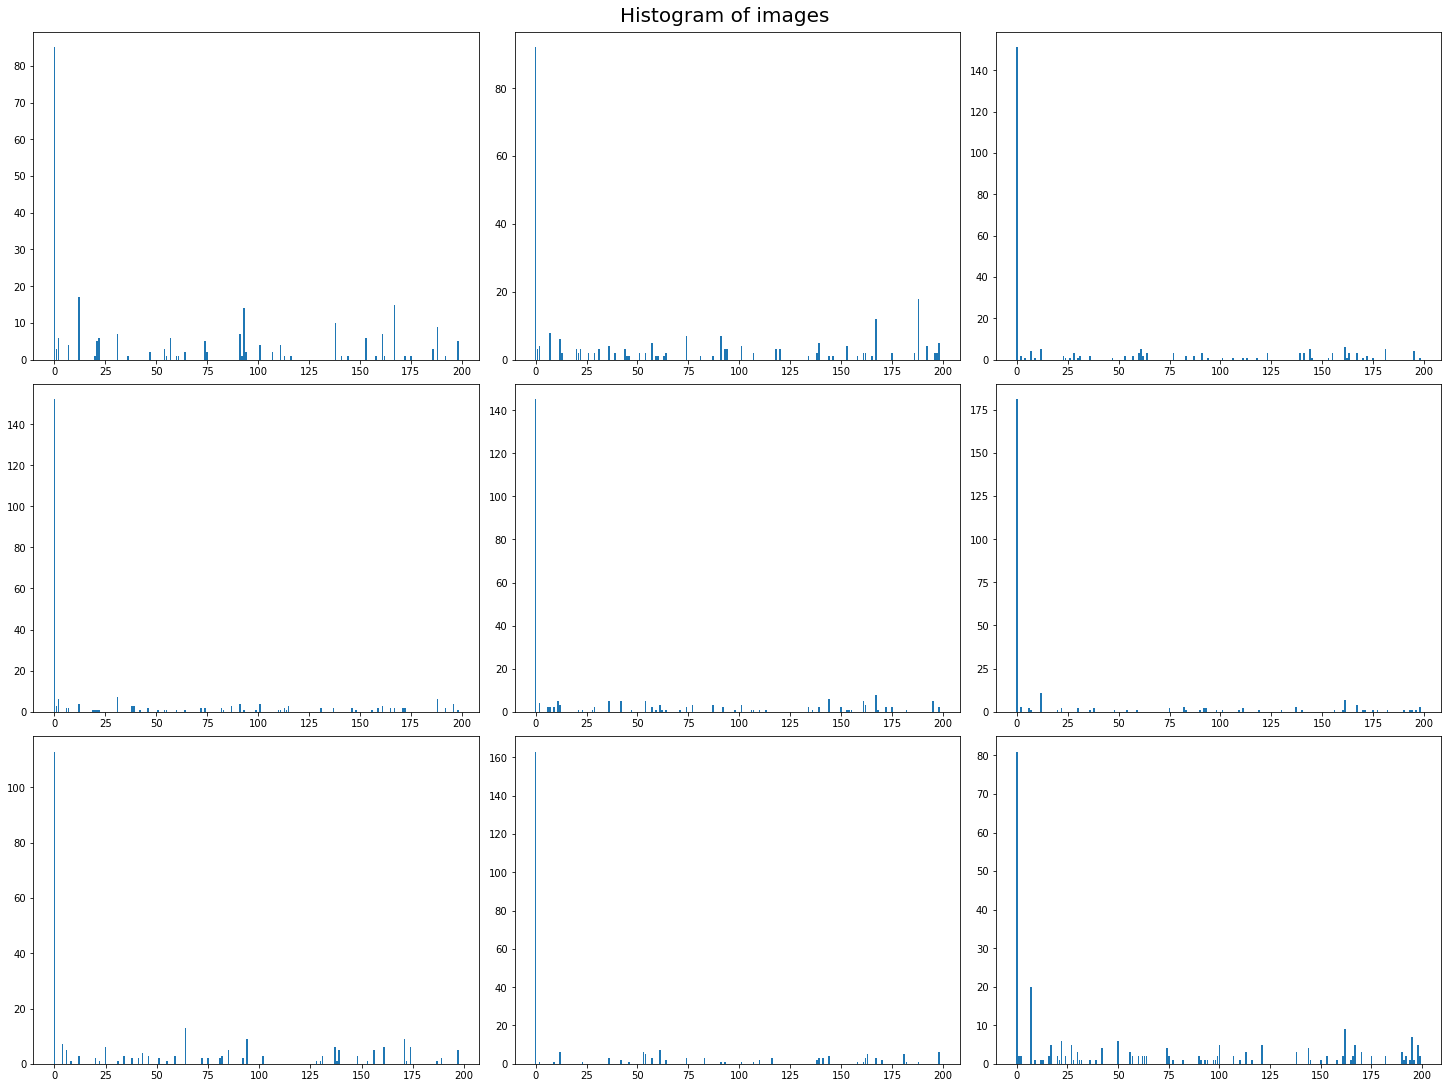

In [13]:
fig, ax = plt.subplots(3,3,figsize=(20,15),constrained_layout=True)

counts = classes = None
fig.suptitle('Histogram of images',size =20)
for i in range(3):
    for j in range(3):
        classes, counts = np.unique(predictions[3*i+j], return_counts=True) 
        ax[i,j].bar(classes, counts, align='center')

In [14]:
image_bow.computeTfIdfScoredMSTD(DATASET)

Calculating tf-idf scores ...


  0%|          | 0/9998 [00:00<?, ?it/s]

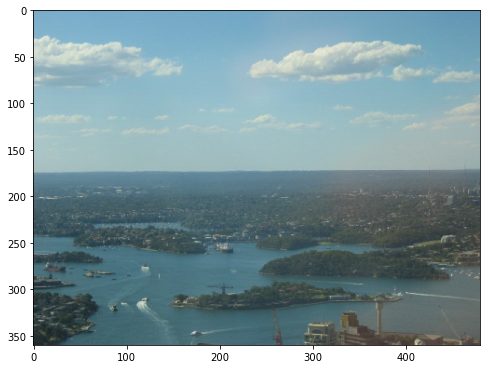

In [15]:
np.random.seed(42)
index = np.random.randint(0,len(DATASET))
query_image = DATASET[index]
plt.figure(figsize=(8,8))
plt.imshow(query_image)

In [16]:
matching_images, matching_scores = image_bow.calculateVisualScore(query_image)

Calculating scores ...


  0%|          | 0/9998 [00:00<?, ?it/s]

In [17]:
matching_images

array([7270, 6231, 6253, 2191, 3606, 6730, 4360, 6971, 3416, 3118],
      dtype=int64)

In [18]:
matching_scores

array([ -4.29669566,  -4.29669566, -30.44033028, -35.74820757,
       -48.64024854, -51.94325681, -53.39160395, -56.22002008,
       -56.81914447, -56.81914447])

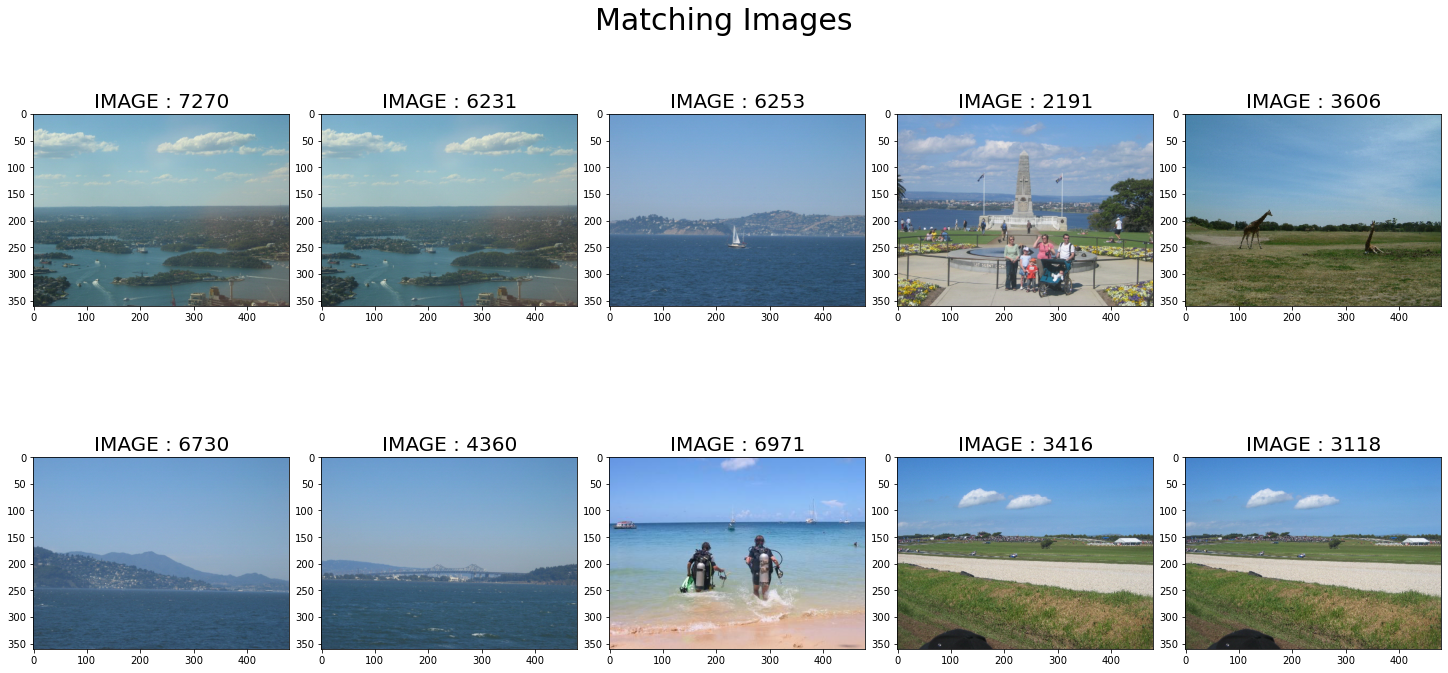

In [19]:
fig, ax = plt.subplots(2,5,figsize=(20,10),constrained_layout=True)

counts = classes = None
fig.suptitle('Matching Images',size =30)
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(DATASET[matching_images[5*i+j]])
        ax[i,j].set_title("IMAGE : "+str(matching_images[5*i+j]), size = 20)

In [20]:
import pickle

In [29]:
# Saving the tf-idf scores, inverse document frequency, K-means estimator object and no of clusters into a file
with open('visualbagofwords.pkl','wb') as output:
    pickle.dump(image_bow, output, pickle.HIGHEST_PROTOCOL)

In [38]:
var = None

with open('visualbagofwords.pkl', 'rb') as file:
    var = pickle.load(file)
        

In [52]:
len(var.tf_idf)

9998